# Practical Assignment 1: Part-of-speech (PoS) Tagging

**Teams**: Pedro Guijas Bravo, Ángel Miguélez Millos.

**Due date**: November 13, 2022.

# 0. Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model


# 1. Load Data

In [ ]:
# English
!wget https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu
!wget https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-test.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu

# Spanish
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/master/es_ancora-ud-train.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/master/es_ancora-ud-test.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/master/es_ancora-ud-dev.conllu

# Galician
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Galician-CTG/master/gl_ctg-ud-train.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Galician-CTG/master/gl_ctg-ud-test.conllu
!wget https://raw.githubusercontent.com/UniversalDependencies/UD_Galician-CTG/master/gl_ctg-ud-dev.conllu

--2022-11-09 18:58:24--  https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu [following]
--2022-11-09 18:58:24--  https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13686411 (13M) [text/plain]
Saving to: ‘en_ewt-ud-train.conllu.3’

en_ewt-ud-train.con 100%[===================>]  13.05M  --.-KB/s    in 0.07s   

2022-11-09 18:58:25 (190 MB/s) - ‘en_e

In [ ]:
def load_conllu(file_name):
  dataset = ([],[])
  words = []
  upos = []
  b=0
  f = open(file_name, "r")
  for line in f:
    splitted_line = line.split()

    # Check end of phrase
    if splitted_line == []:
      #print(words)
      #print(upos)
      dataset[0].append(words)
      dataset[1].append(upos)
      words = []
      upos = []
      continue

    # Check if comment
    if splitted_line[0].isdigit():
      words.append(splitted_line[1])
      upos.append(splitted_line[3])

  # Defensive programming
  assert len(dataset[0])==len(dataset[1])
  assert len(dataset[0][0])==len(dataset[1][0])

  return dataset


# 2. Encode Data (World Tokens, Char Tokens and Label Tokens)

Sentences must be of the same lenght (``MAX_LENGTH`` / ``MAX_LENGTH_WORDS``) because TensorFlow uses Tensors to compute gradients.

Note that this is because tensors are data structures with a defined and static shape.

In [ ]:
# Default params
MAX_LENGTH_WORDS = 128
MAX_LENGTH_CHARS = 16
BATCH_SIZE = 32
MODEL_TYPE = 2
WORD_EMBEDING_SIZE = 32
CHAR_EMBEDING_SIZE = 16
CHAR_EMBEDING_LSTM_SIZE = 64
LSTM_MEMORY_SIZE = 256
LR = 0.001
EPOCHS = 5

In [ ]:
##############
#  POS TAGS  #
##############

def preprocess_tags(raw_tags,tokenizer=None,params={}):

  # Get params
  max_lenght_words = params.setdefault('max_lenght_words', MAX_LENGTH_WORDS)

  if tokenizer is None:
    # Get Classes
    tokenizer = Tokenizer(filters="",oov_token="<unknown>")
    tokenizer.fit_on_texts(raw_tags)
    print(f"POS labels: {tokenizer.word_index}")

  # Encode
  tokenized_labels = tokenizer.texts_to_sequences(raw_tags)

  # Validate equal lenghts of toneks and labels
  for a,b in zip(tokenized_labels,raw_tags):
    assert len(a)==len(b)

  return tokenizer, pad_sequences(tokenized_labels, maxlen=max_lenght_words, padding='post',value=0) # 0's padding

def decode_tags(encoded_tags,tokenizer,one_hot=False):
  if one_hot:
    encoded_tags = np.argmax(encoded_tags, axis=2)
  return [ sample_labels.split() for sample_labels in tokenizer.sequences_to_texts(encoded_tags)]


In [ ]:
#####################
#  Tokenize Inputs  #
#####################

def encode_inputs(raw_imputs,level,tokenizer=None,params={}):

  # Get params
  max_lenght_words = params.setdefault('max_lenght_words', MAX_LENGTH_WORDS)
  max_lenght_chars = params.setdefault('max_lenght_chars', MAX_LENGTH_CHARS)

  if level=="word":
    if tokenizer is None:
      tokenizer = Tokenizer(filters="",oov_token="<u_word>")
      tokenizer.fit_on_texts(raw_imputs)
    return tokenizer, pad_sequences(tokenizer.texts_to_sequences(raw_imputs), maxlen=max_lenght_words, padding='post',value=0) # 0's padding

  elif level=="char":
    if tokenizer is None:
      tokenizer = Tokenizer(filters="",char_level=True,oov_token="<u_char>")
      tokenizer.fit_on_texts([" ".join(phrase) for phrase in raw_imputs])
      num_chars = len(tokenizer.word_index)
    # CAREFULL, to allow the tokenizer to work at char level it should tokenize LIST OF STRINGS (WORDS) (not list of list of words)
    char_encoded = [pad_sequences(tokenizer.texts_to_sequences(phrase), maxlen=max_lenght_chars, padding='post') for phrase in raw_imputs]
    return tokenizer, pad_sequences(char_encoded, maxlen=max_lenght_words, padding='post',value=0) # 0's padding

  else:
    raise "Inputs can only be encoded at word or char level"

def decode_word_inputs(encoded_inputs,tokenizer):
  return [ line.split() for line in tokenizer.sequences_to_texts(encoded_inputs)]

In [ ]:
#######################
#  Generate Datesets  #
#######################

def generate_encoded_datasets(ds_raw_train, ds_raw_dev, ds_raw_test, params={}):

  # Get Params
  batch_size = params.setdefault('batch_size', BATCH_SIZE)
  include_chars = params.setdefault('model_type', MODEL_TYPE) == 2

  # Labels
  print(f"\nRaw outputs exmaple: {ds_raw_train[1][0][0:5]}...")
  label_tokenizer, train_labels = preprocess_tags(ds_raw_train[1],params=params)

  print(f"Outputs encoded exmaple: {train_labels[0][0:5]}...")

  _, dev_labels = preprocess_tags(ds_raw_dev[1], tokenizer=label_tokenizer,params=params)
  _, test_labels = preprocess_tags(ds_raw_test[1], tokenizer=label_tokenizer,params=params)

  print(f"Shapes: {train_labels.shape} {dev_labels.shape} {test_labels.shape}")

  # Word Level
  print(f"\nRaw input exmaple: {ds_raw_train[1][0][0:5]}...")
  tokenizer_word_level, train_inputs_word_level = encode_inputs(ds_raw_train[0], "word", params=params)
  print(f"Word level encoded input exmaple: {train_inputs_word_level[0][0:5][0:2]}...")

  _, dev_inputs_word_level = encode_inputs(ds_raw_dev[0], "word", tokenizer=tokenizer_word_level, params=params)
  _, test_inputs_word_level = encode_inputs(ds_raw_test[0], "word", tokenizer=tokenizer_word_level, params=params)

  print(f"Shapes: {train_inputs_word_level.shape} {dev_inputs_word_level.shape} {test_inputs_word_level.shape}")

  if not include_chars:

    ds_train = tf.data.Dataset.from_tensor_slices((train_inputs_word_level,train_labels))
    ds_train = ds_train.batch(batch_size)
    ds_dev = tf.data.Dataset.from_tensor_slices((dev_inputs_word_level,dev_labels))
    ds_dev = ds_dev.batch(batch_size)
    ds_test = tf.data.Dataset.from_tensor_slices((test_inputs_word_level,test_labels))
    ds_test = ds_test.batch(batch_size)

    return tokenizer_word_level, None, label_tokenizer, ds_train, ds_dev, ds_test

  else:
    # Char Level
    tokenizer_char_level, train_inputs_char_level = encode_inputs(ds_raw_train[0], "char", params=params)
    print(f"Char level encoded input exmaple: {train_inputs_char_level[0][0:3][0:2]}...") # NO ME HACE CASO XD ANGEL HAZ QUE MUESTRE SOLO LOS 3 PRIMEROS CHARS Y DIME QUE HICE MAL, QUE YA ESTOY SATURADO

    _, dev_inputs_char_level = encode_inputs(ds_raw_dev[0], "char", tokenizer=tokenizer_char_level, params=params)
    _, test_inputs_char_level = encode_inputs(ds_raw_test[0], "char", tokenizer=tokenizer_char_level, params=params)

    print(f"Shapes: {train_inputs_char_level.shape} {dev_inputs_char_level.shape} {test_inputs_char_level.shape}")

    # Train
    ds_train_word = tf.data.Dataset.from_tensor_slices(train_inputs_word_level)
    ds_train_char = tf.data.Dataset.from_tensor_slices(train_inputs_char_level)
    ds_train_label = tf.data.Dataset.from_tensor_slices(train_labels)
    ds_train = tf.data.Dataset.zip(((ds_train_word,ds_train_char),ds_train_label))
    ds_train = ds_train.batch(batch_size)
    # Dev
    ds_dev_word = tf.data.Dataset.from_tensor_slices(dev_inputs_word_level)
    ds_dev_char = tf.data.Dataset.from_tensor_slices(dev_inputs_char_level)
    ds_dev_label = tf.data.Dataset.from_tensor_slices(dev_labels)
    ds_dev = tf.data.Dataset.zip(((ds_dev_word,ds_dev_char),ds_dev_label))
    ds_dev = ds_dev.batch(batch_size)
    # Test
    ds_test_word = tf.data.Dataset.from_tensor_slices(test_inputs_word_level)
    ds_test_char = tf.data.Dataset.from_tensor_slices(test_inputs_char_level)
    ds_test_label = tf.data.Dataset.from_tensor_slices(test_labels)
    ds_test = tf.data.Dataset.zip(((ds_test_word,ds_test_char),ds_test_label))
    ds_test = ds_test.batch(batch_size)

    return tokenizer_word_level, tokenizer_char_level, label_tokenizer, ds_train, ds_dev, ds_test



# 3. Create Model

In [ ]:
def create_model(num_words,num_classes,num_chars=None,params={}):

  # Get Params
  word_embeding_size = params.setdefault('word_embeding_size', WORD_EMBEDING_SIZE)
  char_embeding_size = params.setdefault('char_embeding_size', CHAR_EMBEDING_SIZE)
  char_embeding_lstm_size = params.setdefault('char_embeding_lstm_size', CHAR_EMBEDING_LSTM_SIZE)
  lstm_memory_size = params.setdefault('lstm_memory_size', LSTM_MEMORY_SIZE)
  max_lenght_words = params.setdefault('max_lenght_words', MAX_LENGTH_WORDS)
  max_lenght_chars = params.setdefault('max_lenght_chars', MAX_LENGTH_CHARS)
  model_type = params.setdefault('model_type', MODEL_TYPE)

  if model_type==0:
    # Secuantial MODEL (first approach)
    model = keras.Sequential()
    model.add(layers.Embedding(num_words, word_embeding_size, input_length=max_lenght_words, mask_zero=True, name="Word_Embedding"))
    model.add(layers.Bidirectional(layers.LSTM(lstm_memory_size, return_sequences=True), name="LSTM"))
    model.add(layers.TimeDistributed(layers.Dense(num_classes), name="Time_Distributed_Dense"))
    model.add(layers.Activation('softmax', name="Softmax"))

  elif model_type==1:
    # Functional (first approach)
    input = layers.Input(shape=(max_lenght_words), name="Word_Input")
    out = layers.Embedding(num_words, word_embeding_size, input_length=max_lenght_words, mask_zero=True, name="Word_Embedding")(input)
    out = layers.Bidirectional(layers.LSTM(lstm_memory_size, return_sequences=True), name="LSTM")(out)
    out = layers.TimeDistributed(layers.Dense(num_classes), name="Time_Distributed_Dense")(out)
    out = layers.Activation('softmax', name="Softmax")(out)
    model = keras.Model(inputs=input, outputs=out)

  elif model_type==2:
    if num_chars is None:
      raise "Num Chars must be specified"

    # Functional (second approach)
    word_level_input = layers.Input(shape=(max_lenght_words), name="Word_Input")
    word_level = layers.Embedding(num_words, word_embeding_size, input_length=max_lenght_words, mask_zero=True, name="Word_Embedding")(word_level_input)

    char_level_input = layers.Input(shape=(max_lenght_words,max_lenght_chars), name="Char_Input")
    char_level = layers.Embedding(num_chars, char_embeding_size, input_length=max_lenght_chars, mask_zero=True, name="Char_Embedding")(char_level_input)
    char_level = layers.TimeDistributed(layers.LSTM(char_embeding_lstm_size), name="Char_Embedding_LSTM")(char_level)

    out = layers.Concatenate(name="Concatenate")([word_level,char_level])
    out = layers.Bidirectional(layers.LSTM(lstm_memory_size, return_sequences=True), name="LSTM")(out)
    out = layers.TimeDistributed(layers.Dense(num_classes), name="Time_Distributed_Dense")(out)
    out = layers.Activation('softmax', name="Softmax")(out)
    model = keras.Model(inputs=[word_level_input,char_level_input], outputs=out)

  else:
    raise f"Model {model_type} does not exist"

  model.summary()
  plot_model(model, to_file=f"model_{model_type}.png", show_shapes=True, show_layer_names=True)
  return model


# 4. Train and Test



In [ ]:
def setup_gpu():
  device_name = tf.test.gpu_device_name()
  if device_name == '/device:GPU:0':
    tf.device(device_name)
    print("GPU DETECTED")

def train_and_test(model, train_ds, val_ds, test_ds, params={}):

  # Get Params
  lr = params.setdefault('lr', LR)
  epochs = params.setdefault('epochs', EPOCHS)

  # Compile
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

  # Fit
  print("\nTraining...")
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2, callbacks=[callback])

  # Plot ACC
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])

  # Plot Loss
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # Evaluate
  print("\nEvaluating...")
  model.evaluate(test_ds, verbose=2)


# 4. Predictions


In [ ]:
def print_predictions(texts, model, tokenizer_word_level, label_tokenizer, tokenizer_char_level=None, params={}):

  model_type = params.setdefault('model_type', MODEL_TYPE)

  # Mask for test size
  f = lambda x,y: x<y
  print_mask = [f(np.arange(MAX_LENGTH_WORDS),len(x)) for x in texts]

  # Encode Words
  _,w = encode_inputs(texts,"word", tokenizer=tokenizer_word_level, params=params)

  # Predict
  if model_type==0 or model_type==1:
    output = model.predict(w,verbose=0)
  elif model_type==2:
    # Encode Chars
    _,c = encode_inputs(texts,"char", tokenizer=tokenizer_char_level, params=params)
    output = model.predict((w,c),verbose=0)
  else:
    raise f"The type of model {model_type} does not exist"

  # Print
  print("\n")
  for phrases,prediction,p_m in zip(decode_word_inputs(w,tokenizer_word_level),decode_tags(output,label_tokenizer,one_hot=True),print_mask):
    for word,tag,m in zip(phrases,prediction,p_m):
      if m:
        print(f"{word} |> {tag}")
    print("\n------------------------\n")



# 6. Run the experiment

In [ ]:
# Load Eng
ds_raw_train_en = load_conllu("en_ewt-ud-train.conllu")
ds_raw_dev_en = load_conllu("en_ewt-ud-dev.conllu")
ds_raw_test_en = load_conllu("en_ewt-ud-test.conllu")
texts_en=[
    ["Al","-","Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al", "-", "Ani", ",", "the", "preacher" ,"at", "the" ,"mosque", "in", "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border","."],
    ["Hi", ",", "my", "name", "is", "peter"],
    ["angel","usually","kills","teachers"],
    ['I', 'hope', 'that', 'my', 'effort', 'will', 'be', 'rewarded', 'with', 'a', '10', 'in', 'natural', 'language', 'understanding'],
    ['I', 'love', 'Vilares']
]

# Load Esp
ds_raw_train_es = load_conllu("es_ancora-ud-train.conllu")
ds_raw_dev_es = load_conllu("es_ancora-ud-dev.conllu")
ds_raw_test_es = load_conllu("es_ancora-ud-test.conllu")
texts_es=[
    ['Las', 'reservas', 'de', 'oro', 'y', 'divisas', 'de', 'Rusia', 'subieron', '800', 'millones', 'de', 'dólares', 'y', 'el', '26', 'de', 'mayo', 'equivalían', 'a', '19.100', 'millones', 'de', 'dólares', ",", 'informó', 'hoy', 'un', 'comunicado', 'del', 'Banco', 'Central', "."],
    ["Hola", "mi", "nombre", "es", "Pedro"],
    ["Angel","suele","matar","profesores"],
    ['Quiero', 'a', 'Vilares']
]

# Load Gal
ds_raw_train_gal = load_conllu("gl_ctg-ud-train.conllu")
ds_raw_dev_gal = load_conllu("gl_ctg-ud-dev.conllu")
ds_raw_test_gal = load_conllu("gl_ctg-ud-test.conllu")
texts_gal=[
    ['De', 'novo,', 'apréciase', 'unha', 'significativa', 'dependencia', 'entre', 'o', 'nivel', 'de', 'acceso', 'á', 'Internet', 'e', 'determinadas', 'características', 'socioeconómicas', 'dos', 'territorios', ",", 'o', 'que', 'aporta', 'o', 'xa', 'citado', 'factor', 'de', 'matiz', 'importante', 'sobre', 'a', 'avaliación', 'dos', 'datos', 'anteriores',"."],
    ["Hola", "meu", "nome", "é", "Pedro"],
    ['Quero', 'a', 'Vilares']
]

def create_train_test_predict(ds_raw_train,ds_raw_dev,ds_raw_test,texts,params={}):

  # Get Parameters
  model_type = params.setdefault('model_type', MODEL_TYPE)

  # Encode Data
  print(" ENCODE DATA ".center(100, '▀'))
  tokenizer_word_level, tokenizer_char_level, label_tokenizer, ds_train, ds_dev, ds_test = generate_encoded_datasets(ds_raw_train, ds_raw_dev, ds_raw_test, params=params)
  num_words = len(tokenizer_word_level.word_index)
  num_chars = None
  if model_type==2:
    num_chars = len(tokenizer_char_level.word_index) #+ 1 # REVISAR!!! NO DEBIERAMOS NECESITAR EL + 1
  num_classes = len(label_tokenizer.word_index) + 1 # + 1 because of the padding token counts

  # Create the model
  print("\n"+" CREATE MODEL ".center(100, '▀') + "\n")
  model = create_model(num_words, num_classes, num_chars=num_chars, params=params)

  # Train and test
  print("\n"+" TRAIN AND TEST THE MODEL ".center(100, '▀') + "\n")
  train_and_test(model, ds_train, ds_dev, ds_test, params=params)

  # Predict
  print("\n"+" COMPUTE PREDICTIONS ".center(100, '▀'))
  print_predictions(texts, model, tokenizer_word_level, label_tokenizer, tokenizer_char_level=None, params=params)

  return model


GPU DETECTED
▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀ ENCODE DATA ▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀

Raw outputs exmaple: ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ']...
POS labels: {'<unknown>': 1, 'noun': 2, 'punct': 3, 'verb': 4, 'pron': 5, 'adp': 6, 'det': 7, 'adj': 8, 'aux': 9, 'propn': 10, 'adv': 11, 'cconj': 12, 'part': 13, 'sconj': 14, 'num': 15, 'x': 16, 'sym': 17, 'intj': 18}
Outputs encoded exmaple: [10  3 10  3  8]...
Shapes: (12543, 128) (2001, 128) (2077, 128)

Raw input exmaple: ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ']...
Word level encoded input exmaple: [183  16]...
Shapes: (12543, 128) (2001, 128) (2077, 128)
Char level encoded input exmaple: [[ 5 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  

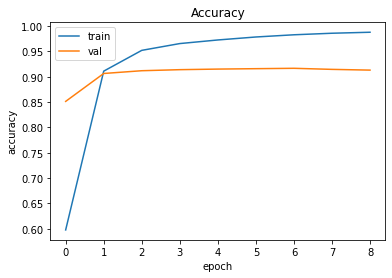

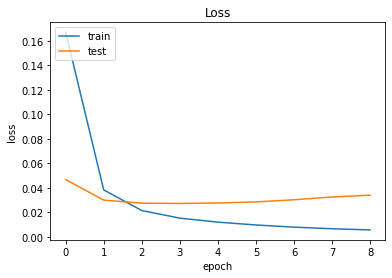


Evaluating...
65/65 - 1s - loss: 0.0296 - accuracy: 0.9195 - 1s/epoch - 17ms/step

▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀ COMPUTE PREDICTIONS ▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀


al |> propn
- |> punct
zaman |> propn
: |> punct
american |> adj
forces |> noun
killed |> verb
shaikh |> propn
abdullah |> propn
al |> propn
- |> punct
ani |> propn
, |> punct
the |> det
preacher |> noun
at |> adp
the |> det
mosque |> noun
in |> adp
the |> det
town |> noun
of |> adp
qaim |> propn
, |> punct
near |> adp
the |> det
syrian |> adj
border |> noun
. |> punct

------------------------

hi |> intj
, |> punct
my |> pron
name |> noun
is |> aux
peter |> propn

------------------------

angel |> noun
usually |> adv
kills |> adj
teachers |> noun

------------------------

i |> pron
hope |> verb
that |> sconj
my |> pron
effort |> noun
will |> aux
be |> aux
rewarded |> verb
with |> adp
a |> det
10 |> num
in |> adp
natural |> adj
language |> noun
understanding |> noun

------------------------

i |> p

In [ ]:
# Set GPU
setup_gpu()

# Params Dict
params = {
  "max_lenght_words": 128,
  "max_lenght_chars": 64,
  "model_type": 2,
  "word_embeding_size": 32,
  "char_embeding_size": 8,
  "char_embeding_lstm_size": 8,
  "lstm_memory_size": 128,
  "batch_size": 32,
  "epochs": 20,
  "lr": 0.001
}

# Run the experiment
create_train_test_predict(ds_raw_train_en,ds_raw_dev_en,ds_raw_test_en,texts_en,params)